In [1]:
#| label: figCebcell

# import data from OSF
from scipy.io import loadmat

# plot figures
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize 
from matplotlib.widgets import Button
from matplotlib.patches import FancyArrow
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from matplotlib.widgets import Button

from import_data_osf2 import get_data

In [8]:
# Function to plot figure

# Function to generate heatmap data
def generate_heatmap_data(iMuscle):
    data_matrix = np.zeros(maps.shape)
    for i in range(ch2xy.shape[0]) :
        data_matrix[int(ch2xy[i][0])][int(ch2xy[i][1])] = sorted_respMean[i][iMuscle]
    return data_matrix  # Generate random heatmap data

# Function to create or update the detailed figure
def update_detailed_figure(iArray, iMuscle, detailed_figure, detailed_axes, d):
    global current_cbar
    
    for key, value in d.items():
        globals()[key] = value

    # Clear previous content
    for ax in detailed_axes:
        ax.clear()
        
    """if current_cbar is not None:
        try:
            current_cbar.remove()
            current_cbar = None
        except Exception as e:
            print(f"Error removing colorbar: {e}")"""
    if current_cbar is not None:
        detailed_figure.delaxes(detailed_figure.axes[3])
    
    n_repetitions = np.where(stim_channel == iArray + 1)[0].shape[0]
    upLim = np.max(sorted_evoked[:,last_button_index]) * 1000
    upCounts = max([np.where(stim_channel == i)[0].shape[0] for i in range(ch2xy.shape[0])])
    # First imshow 
    minSorted = min(np.min(sorted_evoked[iArray, iMuscle, :n_repetitions, :]), np.min(sorted_filtered[iArray, iMuscle, :n_repetitions, :])) * 1000
    maxSorted = max(np.max(sorted_evoked[iArray, iMuscle, :n_repetitions, :]), np.max(sorted_filtered[iArray, iMuscle, :n_repetitions, :])) * 1000
    im1 =  detailed_axes[2].imshow(sorted_evoked[iArray, iMuscle, :n_repetitions, :] * 1000, vmin=minSorted, vmax=maxSorted, aspect='auto', cmap='Blues')
    cax = detailed_figure.add_axes([0.55, 0.15, 0.03, 0.2]) 
    current_cbar =  detailed_axes[2].figure.colorbar(im1, cax=cax)
    current_cbar.ax.set_ylabel("MEP (mV)", rotation=-90, va="bottom", fontsize=fontsize_axes)
    # Overlay isvalid == 0 in red
    for row in np.where(sorted_isvalid[iArray, iMuscle] == 0)[0]:
        detailed_axes[2].scatter(range(sorted_evoked[iArray, iMuscle, :n_repetitions, :].shape[1]), [row] * sorted_evoked[iArray, iMuscle, :n_repetitions, :].shape[1], 
                    c=sorted_evoked[iArray, iMuscle, :n_repetitions, :][row, :] * 1000, cmap='Reds', marker='s', s=10)
        
    divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    x_0 = np.where(time == 0)[0][0]
    step = time.shape[0]//5
    detailed_axes[2].set_xticks([i for i in range(x_0%step,time.shape[0], step)])
    detailed_axes[2].set_xticklabels([np.round(time[i],2) for i in range(x_0%step,time.shape[0], step)])
    detailed_axes[2].set_yticks([i for i in range(n_repetitions)])
    # plt.axvline(resp_region[0] * 1000, color="orange")
    detailed_axes[2].set_xlabel("Time (ms)", fontsize=fontsize_axes)
    detailed_axes[2].set_ylabel("Number of trials", fontsize=fontsize_axes)
    detailed_axes[2].set_title(f"Stack of raw {emgs['emgs'][iMuscle]}  EMG", fontsize=fontsize_title)

    # Plot
    m = np.mean(sorted_filtered[iArray, iMuscle, :n_repetitions, :], axis=0) * 1000
    std = (np.std(sorted_filtered[iArray, iMuscle, :n_repetitions, :] , axis=0, ddof=1)) / np.sqrt(n_repetitions)*1000
    detailed_axes[0].plot(time, m, label=f"Mean EMG")
    
    
    detailed_axes[0].axvline((resp_region[0] - where_zero)/fs * 1000, color="orange", linestyle="dotted", label="Range to compute maximum peak")
    detailed_axes[0].axvline((resp_region[1] - where_zero)/fs * 1000, color="orange", linestyle="dotted")

    detailed_axes[0].set_ylim(0, upLim)
    detailed_axes[0].set_xlabel("Time (ms)", fontsize=fontsize_axes)
    detailed_axes[0].set_ylabel("MEP (mV)", fontsize=fontsize_axes)
    detailed_axes[0].set_title(f"{emgs['emgs'][iMuscle]} ", fontsize=fontsize_title)
    detailed_axes[0].legend(loc=1, fontsize=fontsize_legend)

    # Histogram
    n, bins, patches = detailed_axes[1].hist(sorted_resp[iArray,iMuscle,:n_repetitions] * 1000 , bins=10, density=False, alpha=0.75)

    detailed_axes[1].set_ylim(0, upCounts)
    detailed_axes[1].set_xlim(0, np.max(sorted_resp[:,iMuscle,:]) * 1000)
    detailed_axes[1].set_xlabel('Peak amplitude', fontsize=fontsize_axes)
    detailed_axes[1].set_ylabel('Counts', fontsize=fontsize_axes)
    detailed_axes[1].set_title(f'Distribution of peak amplitude', fontsize=fontsize_title)
    detailed_axes[1].grid(True)
    
    detailed_axes[3].axis('off')
    detailed_figure.suptitle(f'B. MEP details from electrode {iArray}', fontsize=fontsize_title)
    detailed_figure.tight_layout()
    detailed_figure.canvas.draw()
    
# Function to update the heatmap based on button click
def on_button_click(event, iMuscle, fig):
    global heatmap_data, last_button_index  # Access the global variable for heatmap data
    last_button_index = iMuscle
    # Generate new data
    heatmap_data = generate_heatmap_data(iMuscle)
    
    im = ax_heatmap.imshow((heatmap_data-np.min(heatmap_data))/(np.max(heatmap_data)-np.min(heatmap_data)), cmap='Blues')
    ax_heatmap.set_title(emgs['emgs'][iMuscle], fontsize=fontsize_title)  
    # fig.tight_layout()
    
    # Set title and redraw the plot
    fig.canvas.draw()
    
# Function to handle cell click
def on_heatmap_click(event, d, detailed_figure, detailed_axes):
    # Unpack the dictionary into variables
    for key, value in d.items():
        globals()[key] = value
    if event.inaxes == ax_heatmap:
        x, y = event.xdata, event.ydata
        y = ax_heatmap.get_ylim()[1] - y
        x_idx, y_idx = abs(int(round(x))), abs(int(round(y)))
        # print(x_idx, y_idx)
        # Convert data coordinates to pixel coordinates
        trans_data = ax_heatmap.transData
        x_pixel, y_pixel = trans_data.transform((x, y))
        if 0 <= x_idx < heatmap_data.shape[1] and 0 <= y_idx < heatmap_data.shape[0]:  # Check bounds
            cell_value = heatmap_data[y_idx, x_idx]  # Access the heatmap data directly
            iArray = np.intersect1d(np.where(ch2xy[:,1] == x_idx)[0], np.where(ch2xy[:,0] == y_idx)[0])[0]
            # print(f"Cell clicked: ({x_idx}, {y_idx}) with value {cell_value}")  # Debugging statement
            if last_button_index is not None :
                update_detailed_figure(iArray, last_button_index, detailed_figure, detailed_axes, d)

In [4]:
#TO DELETE WHEN ACCESS TO ../DATA

# import data from OSF
from osfclient.api import OSF
import os
from tempfile import NamedTemporaryFile

# Authenticate with OSF (no token needed for public projects)
osf = OSF()

# Access the project by its ID
project_id = '54vhx'
project = osf.project(project_id)
print(f"Connected to project: {project.title}")

# Access the main storage
storage = project.storage('osfstorage')

# Import what is needed
def find_file(storage, target_file_name):
    """
    Search for a file by its name in the OSF storage.
    
    Args:
        storage: OSF storage object
        target_file_name: The name of the target file.
    
    Returns:
        The target file object if found, else None.
    """
    for file in storage.files:
        if file.name == target_file_name:
            return file
    return None

def get_file_data(storage, target_file_name):
    """
    Locate the target file in OSF storage, download its content, and load it into a variable.
    
    Args:
        storage: OSF storage object
        target_file_name: Name of the file to retrieve.
    
    Returns:
        Content of the file as a dictionary (for .mat files).
    """
    # Find the file in storage
    target_file = find_file(storage, target_file_name)
    if not target_file:
        raise FileNotFoundError(f"File '{target_file_name}' not found in storage.")

    # Use a temporary file to save the content
    with NamedTemporaryFile(delete=False, suffix=".mat") as temp_file:
        temp_file_name = temp_file.name
        target_file.write_to(temp_file)  # Write the file content to the temp file

    # Load the data using loadmat
    try:
        data = loadmat(temp_file_name)
    finally:
        # Clean up the temporary file
        os.remove(temp_file_name)

    return data

  
cebus1_data = get_file_data(storage, 'Cebus1_M1_190221.mat')

Connected to project: OptimizeNeurostim


100%|██████████| 148M/148M [00:09<00:00, 15.7Mbytes/s] 


C:\Users\lison\AppData\Local\Temp\ipykernel_3440\1985070844.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax_heatmap, ax_buttons) = plt.subplots(


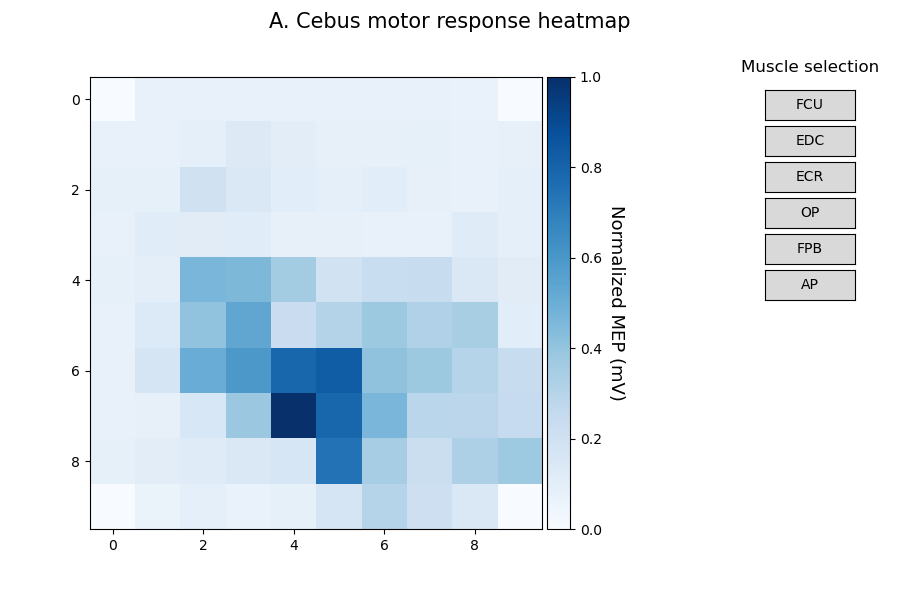

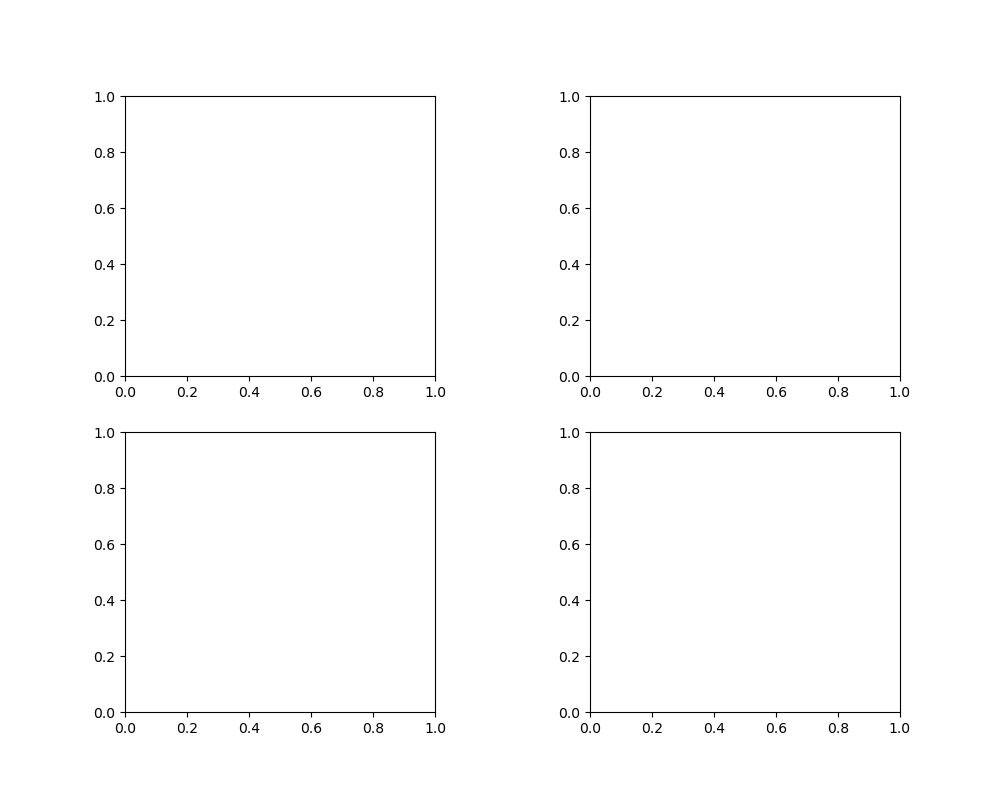

In [16]:
# CEBUS
#cebus1_data = loadmat("../data/Cebus1_M1_190221.mat")
d1 = get_data(is_mat=True, is_rat=False, mat=cebus1_data, name='Cebus1_M1_190221')

# Unpack the dictionary into variables
for key, value in d1.items():
    globals()[key] = value

# Define some plotting parameters
where_zero = np.where(abs(stimProfile) > 10**(-50))[0][0]
time = np.array([i/fs for i in range(-int(where_zero), evoked_emg.shape[2] - int(where_zero))]) * 1000
fontsize_title = 15
fontsize_axes = 13
fontsize_legend = 10
maps1 = np.copy(maps)

# PLOT
maps = maps1
current_cbar = None

# Create a unique identifier for the new main figure

fig_number = max(plt.get_fignums(), default=0) + 1 #len(plt.get_fignums())+ 1  # Total existing figures + 1
fig, (ax_heatmap, ax_buttons) = plt.subplots(
    1, 2, figsize=(9, 6), gridspec_kw={'width_ratios': [4, 1]}, num=f'Main Plot {fig_number}'
)
plt.subplots_adjust(left=0.1, right=0.9, wspace=0.4)
fig.suptitle(f'A. Cebus motor response heatmap', fontsize=fontsize_title)
# Create the initial heatmap plot
heatmap_data = generate_heatmap_data(0)

im = ax_heatmap.imshow(
    (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data)),
    cmap='Blues'
)
divider = make_axes_locatable(ax_heatmap)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = ax_heatmap.figure.colorbar(im, cax=cax)
cbar.ax.set_ylabel("Normalized MEP (mV)", rotation=-90, va="bottom", fontsize=fontsize_axes)

# Initialize button to Muscle 0
last_button_index = 0

# Hide the buttons axis frame
ax_buttons.set_visible(True)
ax_buttons.spines['top'].set_visible(False)
ax_buttons.spines['right'].set_visible(False)
ax_buttons.spines['left'].set_visible(False)
ax_buttons.spines['bottom'].set_visible(False)
ax_buttons.xaxis.set_visible(False)
ax_buttons.yaxis.set_visible(False)
ax_buttons.set_xticks([])
ax_buttons.set_yticks([])

# Create buttons and assign callbacks
button_positions = [0.8 - i * 0.06 for i in range(n_muscles)]  # Vertical positions of buttons
button_axes = [plt.axes([0.85, pos, 0.1, 0.05]) for pos in button_positions]
buttons = [Button(button_axes[i], emgs['emgsabr'][i]) for i in range(n_muscles)]
# Add a title above the buttons
plt.text(0.90, 0.88, "Muscle selection", fontsize=12, ha='center', transform=plt.gcf().transFigure)


for i, button in enumerate(buttons):
    button.on_clicked(lambda event, index=i: on_button_click(event, index, fig))

# Connect the heatmap click event
fig.canvas.mpl_connect('button_press_event', lambda event: on_heatmap_click(event, d1, detailed_figure, detailed_axes))

# Create a unique identifier for the detailed figure
detailed_fig_number = len(plt.get_fignums())  # Total existing figures + 1
detailed_figure, detailed_axes = plt.subplots(
    2, 2, figsize=(10, 8), num=f'Detailed View {detailed_fig_number}'
)
plt.subplots_adjust(wspace=0.5)
detailed_axes = detailed_axes.flatten()